In [2]:
import os
import json
from tqdm import tqdm_notebook

import torch
import numpy as np
import scipy.io.wavfile
import librosa
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize
import scipy.misc
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd

In [3]:
base_male = '.\\gender_recognition_data\\male\\'
base_female = '.\\gender_recognition_data\\female\\'

In [4]:
male_recordings_path = os.listdir(base_male)
female_recordings_path = os.listdir(base_female)


In [5]:
male_recordings_path = list(map(lambda male_audio_path:base_male+male_audio_path, male_recordings_path))
female_recordings_path = list(map(lambda female_audio_path:base_female+female_audio_path, female_recordings_path))
all_file_path = male_recordings_path+female_recordings_path

In [6]:
np.random.seed(25)
np.random.shuffle(male_recordings_path)
np.random.shuffle(female_recordings_path)

In [7]:
example = female_recordings_path[12]
print(example)
ipd.Audio(example)

.\gender_recognition_data\female\0_56_11.wav


Pad singal to the longest signal

In [8]:
def pad_signal(signal, target_len):
    
    num_zeros_needed = target_len - len(signal)
    
    if num_zeros_needed > 0:

        num_zeros_front = np.random.randint(num_zeros_needed)
        num_zeros_back = num_zeros_needed - num_zeros_front
        return np.pad(signal, (num_zeros_front, num_zeros_back), mode='constant')

    else:
        return signal

In [9]:
kPRE_EMPHASIS_COEFF = 0.97
def pre_emphasis(signal):
    first_amp = signal[0]
    all_amps_without_first = signal[1:]
    all_amps_without_last = signal[:-1]
    emphasized_signal = np.append(first_amp, all_amps_without_first - kPRE_EMPHASIS_COEFF * all_amps_without_last)
    return emphasized_signal

In [10]:
def pipeline(signal):
    
    emphasized_signal = pre_emphasis(signal)
    # the following code applies dft, mel filter banks, logging, dct and normalization all at once
    # truly convenient
    
    lifted_mfcc = librosa.feature.mfcc(
        y=emphasized_signal.astype(float), 
        sr=sample_rate, 
        n_mfcc=12, 
        dct_type=2, 
        norm='ortho', 
        lifter=22,
        n_fft = int(sample_rate * 0.025),
        hop_length= int(sample_rate * 0.01),
        power=2,
        center=False,
        window='hanning',
        n_mels=40
    )

    return lifted_mfcc

get maximum length

In [11]:
sample_rate = librosa.core.get_samplerate(male_recordings_path[0])
sample_rate

48000

In [12]:
librosa.core.audio.get_duration(filename = example)

0.8399583333333334

In [13]:
def get_max_duration(filenames):
    """
    Return the maximum duration in seconds for a group of wav files.
    This is much faster than loading all the wav files into numpy arrays and using the shape attribute.
    """
    max_duration = 0
    for fn in filenames:
        duration = librosa.core.audio.get_duration(filename=fn)
        if duration > max_duration:
            max_duration = duration
    return max_duration

In [14]:
max_duration = get_max_duration(all_file_path)
max_duration

0.9999583333333333

In [15]:
max_samples = int(max_duration * sample_rate)
max_samples

47998

In [16]:
def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).

    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.

    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.

    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.

    Examples
    --------
    >>> img = array([[ 91.06794177,   3.39058326,  84.4221549 ],
                     [ 73.88003259,  80.91433048,   4.88878881],
                     [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)

    """
    if data.dtype == np.uint8:
        return data

    if high < low:
        raise ValueError("`high` should be larger than `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data * 1.0 - cmin) * scale + 0.4999
    bytedata[bytedata > high] = high
    bytedata[bytedata < 0] = 0
    return np.cast[np.uint8](bytedata) + np.cast[np.uint8](low)

Creat the dataset

In [25]:
for i,male_path in enumerate(male_recordings_path):
    gender = "0" # 0 for male, 1 for female
    # get recording information from name
    rec_name = male_path.split("\\")[-1]
    number,index,iteration = rec_name.split("_")
    iteration = iteration[0:-4]
    #
    _, signal = scipy.io.wavfile.read(male_path)  # faster than librosa
    
    signal = pad_signal(signal, target_len=max_samples)
    mfc = pipeline(signal)
    mfc_3d = resize(np.rollaxis(np.array([mfc] * 3), 0, 3), (224, 224, 3))
    mfc_3d=bytescale(mfc_3d,cmin=0,cmax=255)
    im = Image.fromarray(mfc_3d)
    break
    im.save("gender_recognition_preprocessed_data/images/{}_{}_{}_{}.jpg".format(number,gender,index,iteration)) #number_gender_index_iteration
    # create the label
    y_numbers = np.zeros(10,dtype="int8")
    y_numbers[int(number)] = 1
    y_gender = np.int_(gender)
    y = np.array([y_numbers,y_gender])
    np.save("gender_recognition_preprocessed_data/labels/{}_{}_{}_{}.npy".format(number,gender,index,iteration),y)
    #
    if i %500 ==0:
        print(i)

In [26]:
print(signal.shape)
np.min(signal)

(47998,)


-812

In [146]:
for i,female_path in enumerate(female_recordings_path):
    gender = "1" # 0 for male, 1 for female
    # get recording information from name
    rec_name = female_path.split("\\")[-1]
    number,index,iteration = rec_name.split("_")
    iteration = iteration[0:-4]
    #
    _, signal = scipy.io.wavfile.read(female_path)  # faster than librosa
    signal = pad_signal(signal, target_len=max_samples)
    mfc = pipeline(signal)
    mfc_3d = resize(np.rollaxis(np.array([mfc] * 3), 0, 3), (224, 224, 3))
    mfc_3d=bytescale(mfc_3d,cmin=0,cmax=255)
    im = Image.fromarray(mfc_3d)
    im.save("gender_recognition_preprocessed_data/images/{}_{}_{}_{}.jpg".format(number,gender,index,iteration)) #number_gender_index_iteration
    # create the label
    y_numbers = np.zeros(10,dtype="int8")
    y_numbers[int(number)] = 1
    y_gender = np.int_(gender)
    y = np.array([y_numbers,y_gender])
    np.save("gender_recognition_preprocessed_data/labels/{}_{}_{}_{}.npy".format(number,gender,index,iteration),y)
    #
    if i %500 ==0:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


Sanity checks

(224, 224, 3)


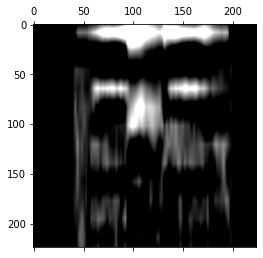

In [29]:
print(mfc_3d.shape)
plt.matshow(mfc_3d)

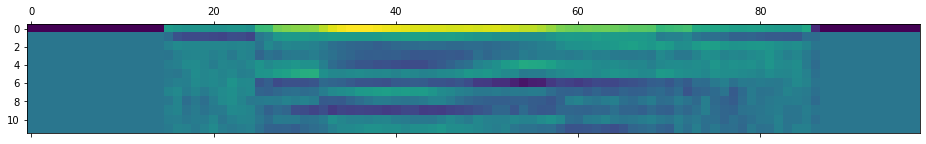

In [148]:
plt.matshow(mfc)

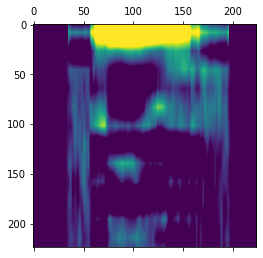

In [149]:
plt.matshow(mfc_3d[:,:,2])

In [161]:
img = Image.open(".\\gender_recognition_preprocessed_data\\images\\0_0_01_0.jpg")
torch.tensor(np.array(img)).shape

torch.Size([224, 224, 3])